In [33]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('artifacts/newdb_aligned.csv', sep='\t', names=['name', 'sequence'])

In [3]:
df.head()

,name,sequence
0,1432|KF859742|O|CCR5,C-ERPTMD--I-QD---I-H--IGP----MA-WY--STYIER-QAK...
1,MD47|KF859744|O|CCR5,C-QRPGHQ-EI-QE---I-K--TGP-----LAWY--SMYLKE-NTT...
2,BCF02|U24562|O|CCR5,C-QRPGHQ-TV-QE---I-R--IGP-----MAWY--SM---G-LAA...
3,152|KF859743|O|CCR5,C-RRPAMK--V-QE---M-R--IGP----MA-WY--SMALEE-GNN...
4,DUR|X84327|O|CCR5,C-VRPGNN-SV-QE---I-K--IGP-----MAWY--SM-----QIE...


In [4]:
# Define Labels
# For CCR5
df['ccr5'] = df.name.str.contains('CCR5')
df['cxcr4'] = df.name.str.contains('CXCR4')
df.head(10)

,name,sequence,ccr5,cxcr4
0,1432|KF859742|O|CCR5,C-ERPTMD--I-QD---I-H--IGP----MA-WY--STYIER-QAK...,True,False
1,MD47|KF859744|O|CCR5,C-QRPGHQ-EI-QE---I-K--TGP-----LAWY--SMYLKE-NTT...,True,False
2,BCF02|U24562|O|CCR5,C-QRPGHQ-TV-QE---I-R--IGP-----MAWY--SM---G-LAA...,True,False
3,152|KF859743|O|CCR5,C-RRPAMK--V-QE---M-R--IGP----MA-WY--SMALEE-GNN...,True,False
4,DUR|X84327|O|CCR5,C-VRPGNN-SV-QE---I-K--IGP-----MAWY--SM-----QIE...,True,False
5,DUR|AM262121|O|CCR5,C-VRPGNN-SV-QE---M-R--VGP--M--A-WY--SM-----ELE...,True,False
6,DUR|AM262130|O|CCR5,C-VRPGNN-SV-KE---M-R--VGP--M--A-LY--SM-----ELE...,True,False
7,DUR|AM262127|O|CCR5,C-VRPGDN-SV-KE---M-R--AGP-----MAWY--SM-----ELE...,True,False
8,CA9|X96522|O|CCR5,C-ERPGNH-TV-QE---I-R--IGP-LA----WY--SM---G-IEK...,True,False
9,BCF01|U24566|O|CCR5,C-HRPGNL-SV-QE---M-K--IGP--LS---WY--SM---G-LAA...,True,False


In [5]:
seq = df.loc[0, 'sequence']

In [6]:
# Function to call labels
def tropism_label(row):
    
    if row.ccr5 and row.cxcr4:
        #return 'dual_tropic'
        return '0'
    elif row.ccr5:
        #return 'CCR5'
        return 1
    elif row.cxcr4:
        #return 'CXCR4'
        return 2

In [7]:
df['label'] = df.apply(tropism_label, axis=1)

In [8]:
df.label.value_counts()

1    2354
2     277
0      48
Name: label, dtype: int64

In [9]:
len(df[(df.ccr5 == False)|(df.cxcr4 == False)])

2631

In [10]:
df.shape

(2679, 5)

In [11]:
df

,name,sequence,ccr5,cxcr4,label
0,1432|KF859742|O|CCR5,C-ERPTMD--I-QD---I-H--IGP----MA-WY--STYIER-QAK...,True,False,1
1,MD47|KF859744|O|CCR5,C-QRPGHQ-EI-QE---I-K--TGP-----LAWY--SMYLKE-NTT...,True,False,1
2,BCF02|U24562|O|CCR5,C-QRPGHQ-TV-QE---I-R--IGP-----MAWY--SM---G-LAA...,True,False,1
3,152|KF859743|O|CCR5,C-RRPAMK--V-QE---M-R--IGP----MA-WY--SMALEE-GNN...,True,False,1
4,DUR|X84327|O|CCR5,C-VRPGNN-SV-QE---I-K--IGP-----MAWY--SM-----QIE...,True,False,1
...,...,...,...,...,...
2674,H13988_DS2|JF508074|B|CCR5,C-TRPNNN-TR-KS---I-H--IGP-GK--A-FY--TT---G-EII...,True,False,1
2675,H13988_DS2|JF508043|B|CCR5,C-TRPNNN-TR-KS---I-P--IGP-GK--A-FY--TT---G-EII...,True,False,1
2676,39|AF022258|B|CCR5,C-TRPNNN-TR-KS---I-S--IGP-GR--A-FY--TT---G-EII...,True,False,1
2677,122|DQ002264|B|CCR5,C-TRPNNN-TR-KS---I-P--IGP-GR--A-FY--TT---G-EII...,True,False,1


In [12]:
# Check of len of sequence is the same for all rows
set(df['sequence'].apply(len))

{60}

## Converting Protein Sequence to Vectors

In [13]:
df_aa = pd.read_csv('artifacts/aminoacids_oneletter_code.csv', sep='\t')

In [14]:
df_aa

,Pos_array,3-letters-code,1-letter-code,Aminoacid
0,1.0,Ala,A,Alanine
1,2.0,Asn,N,Asparagine
2,3.0,Asp,D,Aspartic acid
3,4.0,Cys,C,Cysteine
4,5.0,Gln,Q,Glutamine
5,6.0,Glu,E,Glutamic acid
6,7.0,Gly,G,Glycine
7,8.0,His,H,Histidine
8,9.0,Ile,I,Isoleucine
9,10.0,Leu,L,Leucine


In [15]:
df_aa['1-letter-code'].to_list()

['A',
 'N',
 'D',
 'C',
 'Q',
 'E',
 'G',
 'H',
 'I',
 'L',
 'K',
 'M',
 'F',
 'P',
 'O',
 'S',
 'U',
 'T',
 'W',
 'Y',
 'V',
 'B',
 'Z',
 'X',
 'J',
 '-']

In [162]:
def get_array_from_sequence(seq):
    dict_aa_pos = {
    'A':1, 'R':2, 'N':3, 'D':4, 'C':5, 'Q':6, 'E':7, 'G':8,
    'H':9, 'I':10, 'L':11, 'K':12, 'M':13, 'F':14, 'P':15, 
    'O':16, 'S':17, 'U':18, 'T':19, 'W':20, 'Y':21, 'V':22, 
    'B':23, 'Z':24, 'J':25, 'X':0, }
    
    f_array = np.zeros(26)
    for aa in seq:
        arr = np.zeros(26)
        if dict_aa_pos.get(aa):
            arr[dict_aa_pos.get(aa)] = 1
        f_array = np.vstack((f_array, arr))
    f_array = np.delete(f_array, 0,0)
    
    return torch.from_numpy((f_array.flatten()).astype(float))
    

In [163]:
ex = get_array_from_sequence('C-ERPTMD--I-QD---I-H--IGP----MA-WY--STYIER-QAK--G--N-RTRLAYC')

In [167]:
sum(ex)

tensor(37., dtype=torch.float64)

In [168]:
df.loc[0, 'sequence']

'C-ERPTMD--I-QD---I-H--IGP----MA-WY--STYIER-QAK--G--N-RTRLAYC'

In [169]:
# Create list to append data from the df
list_data = []
list_labels = []

# Convert the sequences and labels to arrays to use as data on pytorch
for index, row in df.iterrows():
    list_data.append(get_array_from_sequence(str(row.sequence)))
    list_labels.append(int(row.label))
    

In [172]:
list_data[0]

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

In [70]:
list_data[0].shape

torch.Size([1560])

In [173]:
len(list_labels)

2679

In [174]:
batch_size = 32
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(list_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

In [175]:
split

535

In [176]:
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [177]:
len(val_indices)

535

In [179]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

# To transform list_data and list_labels on trainloader

# For training
train_data = []
for i in train_indices:
    train_data.append([list_data[i], list_labels[i]])

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

# For validation
test_data = []
for j in val_indices:
    test_data.append([list_data[j], list_labels[j]])

test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=32)


In [180]:
import torch.nn as nn
import torch.nn.functional as F

# Define the class Net
class Net(nn.Module):
    def __init__(self):    
        # Define all the parameters of the net
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1560, 200)
        self.fc2 = nn.Linear(200, 3)

    def forward(self, x):   
        # Do the forward pass
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = Net()
model = model.float()

In [193]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # input channel = 1, output channel = 6, kernel_size = 5
        # input size = (32, 32), output size = (28, 28)
        self.conv1 = nn.Conv2d(1, 6, 5)
        # input channel = 6, output channel = 16, kernel_size = 5
        # input size = (14, 14), output size = (10, 10)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # input dim = 16*5*5, output dim = 120
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # input dim = 120, output dim = 84
        self.fc2 = nn.Linear(120, 84)
        # input dim = 84, output dim = 10
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        # pool size = 2
        # input size = (28, 28), output size = (14, 14), output channel = 6
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # pool size = 2
        # input size = (10, 10), output size = (5, 5), output channel = 16
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        # input dim = 16*5*5, output dim = 120
        x = F.relu(self.fc1(x))
        # input dim = 120, output dim = 84
        x = F.relu(self.fc2(x))
        # input dim = 84, output dim = 10
        x = self.fc3(x)
        return x

model = LeNet()
model = model.float()

In [147]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = nn.Conv2d(3, 6, 5)
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(1560, 830)
        self.fc2 = nn.Linear(830, 100)
        self.fc3 = nn.Linear(100, 3)

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()
model = model.float()

In [194]:
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [195]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [205]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #print(running_loss)
        if i % 1000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.001
[2,     1] loss: 0.000
[3,     1] loss: 0.000
[4,     1] loss: 0.000
[5,     1] loss: 0.001
[6,     1] loss: 0.001
[7,     1] loss: 0.000
[8,     1] loss: 0.000
[9,     1] loss: 0.002
[10,     1] loss: 0.001
[11,     1] loss: 0.000
[12,     1] loss: 0.000
[13,     1] loss: 0.000
[14,     1] loss: 0.000
[15,     1] loss: 0.001
[16,     1] loss: 0.000
[17,     1] loss: 0.000
[18,     1] loss: 0.000
[19,     1] loss: 0.001
[20,     1] loss: 0.000
[21,     1] loss: 0.001
[22,     1] loss: 0.001
[23,     1] loss: 0.000
[24,     1] loss: 0.000
[25,     1] loss: 0.000
[26,     1] loss: 0.000
[27,     1] loss: 0.000
[28,     1] loss: 0.000
[29,     1] loss: 0.001
[30,     1] loss: 0.000
[31,     1] loss: 0.000
[32,     1] loss: 0.001
[33,     1] loss: 0.000
[34,     1] loss: 0.000
[35,     1] loss: 0.002
[36,     1] loss: 0.000
[37,     1] loss: 0.001
[38,     1] loss: 0.001
[39,     1] loss: 0.000
[40,     1] loss: 0.000
[41,     1] loss: 0.000
[42,     1] loss: 0.000
[

In [209]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images.float())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


In [210]:
correct

511

In [208]:
total

535

In [92]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
        #running_loss = 0.0

print('Finished Training')

IndentationError: expected an indented block (<ipython-input-92-2386f557722c>, line 3)

### Pytorch Train a classifier Tutorial
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [93]:
import torch
import torchvision
import torchvision.transforms as transforms

In [94]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170237952/170498071 [00:42<00:00, 5247626.11it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


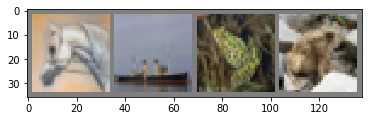

horse  ship  frog  frog


170500096it [01:00, 5247626.11it/s]                               

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [97]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [98]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [99]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.234
[1,  4000] loss: 1.898
[1,  6000] loss: 1.698
[1,  8000] loss: 1.583
[1, 10000] loss: 1.512
[1, 12000] loss: 1.463
[2,  2000] loss: 1.409
[2,  4000] loss: 1.369
[2,  6000] loss: 1.353
[2,  8000] loss: 1.319
[2, 10000] loss: 1.311
[2, 12000] loss: 1.252
Finished Training


### DataCamp Deep Learning with Pytorch tutorial


In [36]:
# Define the class Net
class Net(nn.Module):
    def __init__(self):    
        # Define all the parameters of the net
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1560, 200)
        self.fc2 = nn.Linear(200, 3)

    def forward(self, x):   
        # Do the forward pass
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [65]:
# Instantiate the Adam optimizer and Cross-Entropy loss function

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [66]:
for batch_idx, data_target in enumerate(train_loader):
    data = data_target[0]
    target = data_target[1]
    data = data.view(-1, 1560)
    optimizer.zero_grad()

    # Complete a forward pass
    output = model(data)

    # Compute the loss, gradients and change the weights
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #4 'mat1'

In [ ]:
### Using Will Koersten approach for Pytorch
https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

In [40]:
# Defining dataloader
"""
from torch.utils.data.sampler import SubsetRandomSampler
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(list_data, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(list_data, batch_size=batch_size,
                                                sampler=valid_sampler)
"""

'\nfrom torch.utils.data.sampler import SubsetRandomSampler\n# Creating PT data samplers and loaders:\ntrain_sampler = SubsetRandomSampler(train_indices)\nvalid_sampler = SubsetRandomSampler(val_indices)\n\ntrain_loader = torch.utils.data.DataLoader(list_data, batch_size=batch_size, \n                                           sampler=train_sampler)\nvalidation_loader = torch.utils.data.DataLoader(list_data, batch_size=batch_size,\n                                                sampler=valid_sampler)\n'

## Building the Network
https://www.kaggle.com/sdelecourt/cnn-with-pytorch-for-mnist


In [41]:

y = np.array(list_labels).astype(float)
X = np.array(list_data).astype(float)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(y_test.shape)

NameError: name 'train_test_split' is not defined

In [42]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

NameError: name 'X_train' is not defined

In [60]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable


from sklearn.model_selection import train_test_split


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(1560,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,3)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)

mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=1560, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=3, bias=True)
)


In [44]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))
    error = nn.CrossEntropyLoss()
    EPOCHS = 50
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            #print(correct)
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), 
                    len(train_loader.dataset), 
                    100.*batch_idx / len(train_loader), 
                    loss.item(), 
                    float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [45]:
fit(mlp, train_loader)


TypeError: Variable data has to be a tensor, but got tuple

### Will Koehrsen Approach

In [182]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Trying this approach https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [183]:
input_size = 1560
hidden_sizes = [128, 64]
output_size = 3

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=1560, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
  (5): LogSoftmax()
)


In [184]:
criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))

In [185]:
images = images.view(images.shape[0], -1)


In [186]:
images.shape

torch.Size([64, 1560])

In [187]:
logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #4 'mat1'

In [114]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [134]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 200
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [135]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

## Trainning the model

In [136]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [137]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), '/results/model.pth')
            torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [138]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [139]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 10 1, but got 2-dimensional input of size [100, 1560] instead

## Using the Pytorch Dataloader
### Check this article https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/

After

In [10]:
import bz2
from collections import Counter
import re
import nltk
import numpy as np
nltk.download('punkt')

train_file = bz2.BZ2File('./amazonreviews/train.ft.txt.bz2')
test_file = bz2.BZ2File('./amazonreviews/test.ft.txt.bz2')

train_file = train_file.readlines()
test_file = test_file.readlines()

[nltk_data] Downloading package punkt to /home/gabriel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
num_train = 800000  # We're training on the first 800,000 reviews in the dataset
num_test = 200000  # Using 200,000 reviews from test set

train_file = [x.decode('utf-8') for x in train_file[:num_train]]
test_file = [x.decode('utf-8') for x in test_file[:num_test]]

In [14]:
train_file[0]

'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [15]:
# Extracting labels from sentences
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

# Some simple cleaning of data
for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])

# Modify URLs to <url>
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [16]:
words = Counter()  # Dictionary that will map a word to the number of times it appeared in all the training sentences
for i, sentence in enumerate(train_sentences):
    # The sentences will be stored as a list of words/tokens
    train_sentences[i] = []
    for word in nltk.word_tokenize(sentence):  # Tokenizing the words
        words.update([word.lower()])  # Converting all the words to lowercase
        train_sentences[i].append(word)
    if i%20000 == 0:
        print(str((i*100)/num_train) + "% done")
print("100% done")

0.0% done
2.5% done
5.0% done
7.5% done
10.0% done
12.5% done
15.0% done
17.5% done
20.0% done
22.5% done
25.0% done
27.5% done
30.0% done
32.5% done
35.0% done
37.5% done
40.0% done
42.5% done
45.0% done
47.5% done
50.0% done
52.5% done
55.0% done
57.5% done
60.0% done
62.5% done
65.0% done
67.5% done
70.0% done
72.5% done
75.0% done
77.5% done
80.0% done
82.5% done
85.0% done
87.5% done
90.0% done
92.5% done
95.0% done
97.5% done
100% done


In [17]:
# Removing the words that only appear once
words = {k:v for k,v in words.items() if v>1}
# Sorting the words according to the number of appearances, with the most common word being first
words = sorted(words, key=words.get, reverse=True)
# Adding padding and unknown to our vocabulary so that they will be assigned an index
words = ['_PAD','_UNK'] + words
# Dictionaries to store the word to index mappings and vice versa
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

In [18]:
for i, sentence in enumerate(train_sentences):
    # Looking up the mapping dictionary and assigning the index to the respective words
    train_sentences[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

for i, sentence in enumerate(test_sentences):
    # For test sentences, we have to tokenize the sentences as well
    test_sentences[i] = [word2idx[word.lower()] if word.lower() in word2idx else 0 for word in nltk.word_tokenize(sentence)]

In [19]:
# Defining a function that either shortens sentences or pads sentences with 0 to a fixed length
def pad_input(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

seq_len = 200  # The length that the sentences will be padded/shortened to

train_sentences = pad_input(train_sentences, seq_len)
test_sentences = pad_input(test_sentences, seq_len)

# Converting our labels into numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [36]:
train_sentences[0:3]

array([[     0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0, 

In [26]:
len(train_sentences)

800000

In [30]:
train_labels[0:400]

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

train_data = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_sentences), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

batch_size = 400

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [ ]:
###